In [1]:

import hydra
import sys
sys.path.insert(0, "./src")

# hydra can only be initialized once
hydra.initialize(config_path="configs", version_base=None)

hydra.initialize()

In [2]:
from models.loupe.configuration_loupe import LoupeConfig
from models.loupe.modeling_loupe import LoupeModel
from models.loupe.image_precessing_loupe  import LoupeImageProcessor
from lit_model import LitModel

# NOTE: set stage and checkpoint path here
cfg = hydra.compose(config_name="base", overrides=["stage=seg"])
cfg.ckpt.checkpoint_paths = ["/gemini/code/loupe/checkpoints/seg/model.safetensors"]
loupe_config = LoupeConfig(stage=cfg.stage.name, **cfg.model)
loupe = LoupeModel(loupe_config)
model = LitModel(cfg, loupe)
processor = LoupeImageProcessor(loupe_config)


/root/miniconda3/envs/loupe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-15 11:41:56,471] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/lib

Missing keys for loading vision encoder: []
Unexpected keys for loading vision encoder: ['proj']


2025-05-15 11:42:04.347 | INFO     | lit_model:__init__:45 - Loading checkpoint from /gemini/code/loupe/checkpoints/seg/model.safetensors


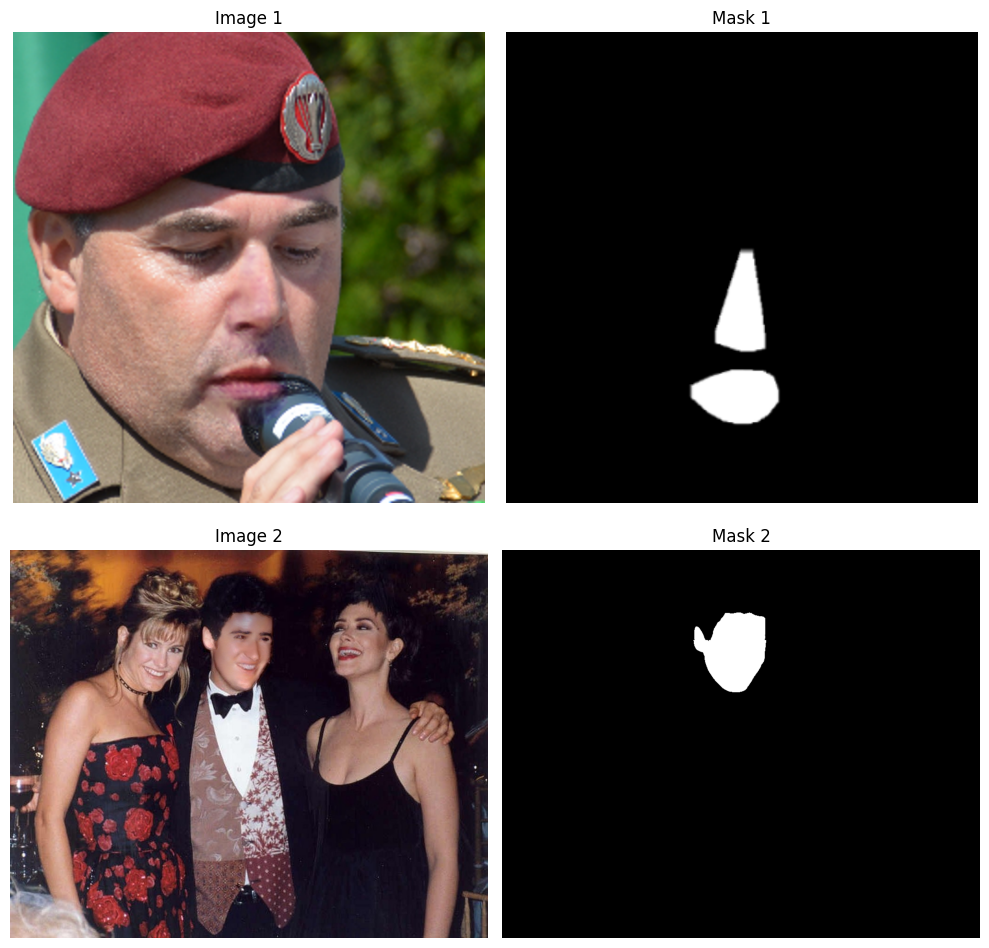

In [3]:
import os
import matplotlib.pyplot as plt
from datasets import load_dataset

validset = load_dataset(
    "parquet", data_files=os.path.join(cfg.data_dir, "valid.parquet")
)
image, mask = validset["train"][0]["image"], validset["train"][0]["mask"]
image2, mask2 = validset["train"][1]["image"], validset["train"][1]["mask"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot images and masks
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Image 1")
axes[0, 1].imshow(mask, cmap='gray')
axes[0, 1].set_title("Mask 1")
axes[1, 0].imshow(image2, cmap='gray')
axes[1, 0].set_title("Image 2")
axes[1, 1].imshow(mask2, cmap='gray')
axes[1, 1].set_title("Mask 2")

# Hide axis ticks
for ax in axes.flatten():
    ax.axis('off')

# Adjust layout for better presentation
plt.tight_layout()
plt.show()

In [4]:
import torch
if cfg.stage.name == "seg":
    inputs = processor(image, mask, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    segmentation = processor.post_process_segmentation(
        outputs, target_sizes=[(512, 512)]
    )
else:
    real_images = []
    for i in range(len(validset["train"]) - 1, len(validset["train"]) - 20, -1):
        if validset["train"][i]["mask"] is None:
            real_images.append(validset["train"][i]["image"])
    inputs = processor(real_images, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

In [ ]:
class TverskyLoss(nn.Module):
    """
    Tversky loss for binary masks.
    Args:
        alpha (float): Weight for false positives.
        beta (float): Weight for false negatives.
        reduction (str): 'batchmean' | 'sum' | 'none' (default: 'batchmean').
    """

    def __init__(self, alpha=0.5, beta=0.5, reduction="batchmean"):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Args:
            inputs (Tensor): Raw logits from the model.
            labels (Tensor): Ground-truth masks (binary). Same shape as inputs.
        Returns:
            Tensor: Scalar loss.
        """
        probs = inputs.sigmoid().flatten(1)
        labels = labels.flatten(1).float()

        TP = (probs * labels).sum(-1)
        FP = (probs * (1 - labels)).sum(-1)
        FN = ((1 - probs) * labels).sum(-1)

        tversky = (TP + 1e-6) / (TP + self.alpha * FP + self.beta * FN + 1e-6)
        loss = 1.0 - tversky

        if self.reduction == "batchmean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss
